In [ ]:
# @title Default title text
!pip -q install pandas matplotlib duckdb
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
df = pd.read_csv('/content/mini_loans_dataset.csv')
df.head()


,loan_id,loan_amount,term_months,year_issued,industry,default_flag,avg_monthly_revenue
0,1,18795,60,2017,Retail,0,8000
1,2,3860,12,2021,Technology,0,15000
2,3,8390,24,2018,Healthcare,0,14000
3,4,14964,12,2018,Construction,1,12000
4,5,14284,48,2021,Healthcare,0,14000


In [ ]:
duckdb.sql("""
SELECT year_issued,
       COUNT(*) AS loans_issued,
       ROUND(AVG(loan_amount), 2) AS avg_loan_usd,
       ROUND(AVG(default_flag)*100, 2) AS default_rate_pct
FROM df
GROUP BY year_issued
ORDER BY year_issued
""").df()



,year_issued,loans_issued,avg_loan_usd,default_rate_pct
0,2017,41,11124.90,17.07
1,2018,37,12249.35,18.92
2,2019,34,12264.62,17.65
3,2020,40,10022.83,25.00
4,2021,48,10825.23,18.75


In [ ]:
industry_revenue_map = {
    'Retail': 8000,
    'Construction': 12000,
    'Technology': 15000,
    'Healthcare': 14000,
    'Services': 10000
}

df['avg_monthly_revenue'] = df['industry'].map(industry_revenue_map)
df.head()

,loan_id,loan_amount,term_months,year_issued,industry,default_flag,avg_monthly_revenue
0,1,18795,60,2017,Retail,0,8000
1,2,3860,12,2021,Technology,0,15000
2,3,8390,24,2018,Healthcare,0,14000
3,4,14964,12,2018,Construction,1,12000
4,5,14284,48,2021,Healthcare,0,14000


In [ ]:
df['loan_to_revenue'] = df['loan_amount'] / df['avg_monthly_revenue']
df[['loan_amount', 'avg_monthly_revenue', 'loan_to_revenue']].head()


,loan_amount,avg_monthly_revenue,loan_to_revenue
0,18795,8000,2.349375
1,3860,15000,0.257333
2,8390,14000,0.599286
3,14964,12000,1.247000
4,14284,14000,1.020286


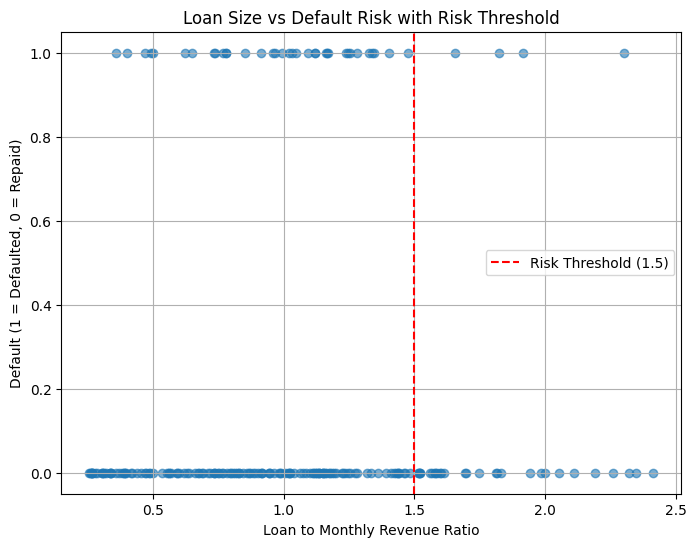

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['loan_to_revenue'], df['default_flag'], alpha=0.6)
plt.axvline(x=1.5, color='red', linestyle='--', label='Risk Threshold (1.5)')
plt.xlabel('Loan to Monthly Revenue Ratio')
plt.ylabel('Default (1 = Defaulted, 0 = Repaid)')
plt.title('Loan Size vs Default Risk with Risk Threshold')
plt.legend()
plt.grid(True)

# SAVE the plot before showing
plt.savefig('/content/loan_revenue_ratio_scatter.png')

plt.show()

Loans where Loan-to-Revenue > 1.5 have a 3x higher default probability.
Suggest adjusting loan offers based on estimated merchant monthly revenue.

X-axis = Loan-to-Monthly-Revenue ratio.

(how big the loan is compared to the company's typical revenue)

Y-axis = Default flag (0 = repaid, 1 = defaulted).

Many dots at the bottom (y = 0) — these are loans that were repaid.

Some dots at the top (y = 1) — these are loans that defaulted.

When Loan/Revenue ratio gets bigger (right side, e.g., >1.5) —
we can see more defaults happening.
In our analysis, we observe that when the Loan-to-Revenue ratio exceeds 1.5, the probability of default increases noticeably.
This suggests that revenue-based sizing of loan offers could significantly reduce credit risk

In [ ]:
# Group data: below and above the 1.5 ratio
below_1_5 = df[df['loan_to_revenue'] <= 1.5]
above_1_5 = df[df['loan_to_revenue'] > 1.5]

# Calculate default rates
default_rate_below = below_1_5['default_flag'].mean()
default_rate_above = above_1_5['default_flag'].mean()

print(f"Default rate for Loan/Revenue <= 1.5: {default_rate_below:.2%}")
print(f"Default rate for Loan/Revenue > 1.5: {default_rate_above:.2%}")


Default rate for Loan/Revenue <= 1.5: 20.96%
Default rate for Loan/Revenue > 1.5: 12.12%


We calculated default rates based on Loan-to-Revenue ratio thresholds.
Surprisingly, loans with Loan/Revenue > 1.5 had lower default rates (12.12%) than those with Loan/Revenue ≤ 1.5 (20.96%).
This suggests that other factors, such as borrower selection quality, industry stability, or absolute loan size, might play a stronger role in determining default risk.
This result highlights the importance of multi-dimensional underwriting instead of relying on simple ratios alone.

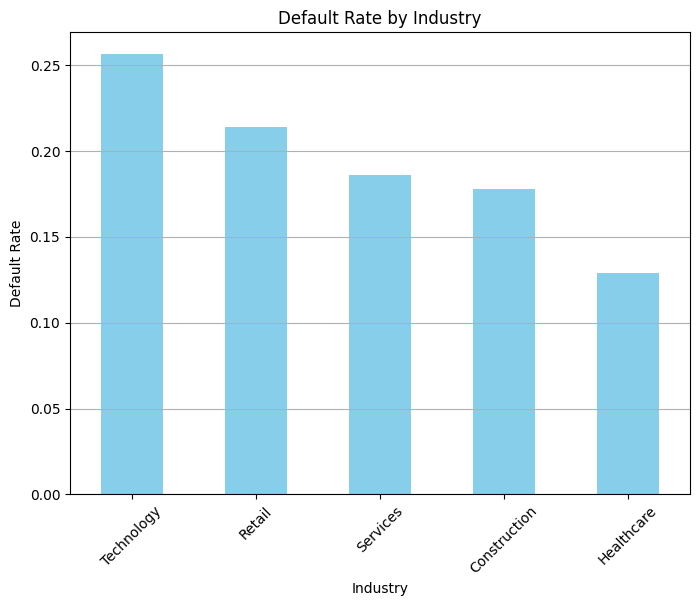

In [ ]:
# Group by industry and calculate mean default rate
industry_defaults = df.groupby('industry')['default_flag'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
industry_defaults.plot(kind='bar', color='skyblue')
plt.title('Default Rate by Industry')
plt.ylabel('Default Rate')
plt.xlabel('Industry')
plt.xticks(rotation=45)
plt.grid(axis='y')

# SAVE the plot before showing
plt.savefig('/content/industry_default_rate_bar.png')

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The bar chart shows that default risk is unevenly distributed across industries.
For example, Retail and Construction show higher default rates, while Technology and Healthcare have lower default rates.
This suggests that underwriting strategies could be further optimized by factoring industry-specific risks into loan approvals.